In [ ]:
import pandas as pd
from sklearn.preprocessing import PowerTransformer
import numpy as np
import shap
import pandas as pd
import miceforest as mf
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.ensemble   import RandomForestRegressor, AdaBoostRegressor
from xgboost           import XGBRegressor
from sklearn.metrics  import mean_absolute_error, r2_score
from sklearn.base      import clone
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



#opties
pd.set_option('display.float_format', '{:.0f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [ ]:
df = pd.read_csv(r'C:\Users\UNMAWI\OneDrive - VLC & Partners\Documenten\AAAAAAAAAAAAAScriptie\Scritpie+data\df_final.csv', sep=',')

In [25]:
df = df.drop(columns=['soort_klant'])

In [26]:
missing_percent = df.isnull().mean() * 100
print(missing_percent.sort_values(ascending=False))

aantal_documenten_slimdossier                                  72
ewa_verzekerdbedrag                                            56
ewa_netto_premie                                               56
aantal_werknemers                                              43
aantal_objecten                                                41
activiteiten                                                   31
processen_geopend                                              17
processen_afgesloten                                           17
processen_actief                                               17
processen_aantal                                               17
processen_open                                                 17
sbi_code                                                       11
minuten_soort_dvo_CLAIM                                         0
minuten_soort_dvo_OVERIG                                        0
freq_soort_dvo_ADVIES                                           0
minuten_so

NA invullen

Na miceforest imputatie:
 activiteiten            0
processen_geopend       0
processen_afgesloten    0
processen_open          0
processen_actief        0
processen_aantal        0
ewa_verzekerdbedrag     0
ewa_netto_premie        0
aantal_werknemers       0
aantal_objecten         0
dtype: int64


<Figure size 1000x600 with 0 Axes>

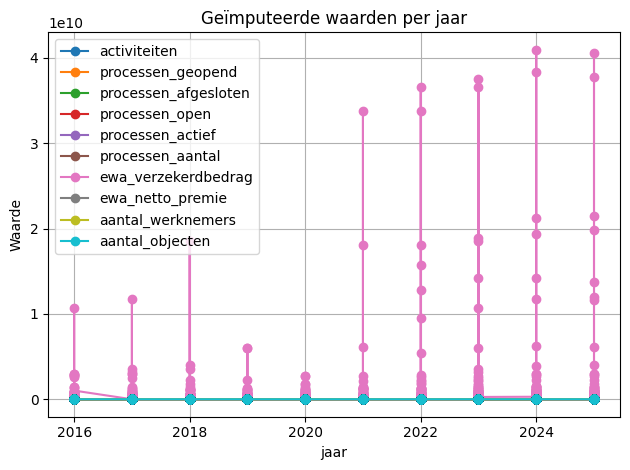

In [ ]:
# Sort
df = df.sort_values('jaar').reset_index(drop=True)


df['aantal_werknemers_missing'] = df['aantal_werknemers'].isna()

# columnsto impute
kolommen = [
    'activiteiten',
    'processen_geopend',
    'processen_afgesloten',
    'processen_open',
    'processen_actief',
    'processen_aantal',
    'ewa_verzekerdbedrag',
    'ewa_netto_premie',
    'aantal_werknemers',
    'aantal_objecten',
]

# Extra pred
extra_predictors = [
    'jaar',
    'frequentie_taakregistratie',
"unieke_polissen_subbranche_AANSPRAKELIJKHEID",
"unieke_polissen_subbranche_BRAND",
"unieke_polissen_subbranche_KREDIET",
"unieke_polissen_subbranche_MEDISCHE VARIA",
"unieke_polissen_subbranche_MOTORRIJTUIGEN",
"unieke_polissen_subbranche_ONGEVALLEN",
"unieke_polissen_subbranche_RECHTSBIJSTAND",
"unieke_polissen_subbranche_REIS",
"unieke_polissen_subbranche_TRANSPORT",
"unieke_polissen_subbranche_VARIA",
"unieke_polissen_subbranche_ZIEKTEKOSTEN",
"unieke_polissen_coassurantiemaatschappij_soort_Adm. Volmacht",
"unieke_polissen_coassurantiemaatschappij_soort_Beurs",
"unieke_polissen_coassurantiemaatschappij_soort_Pakket",
"unieke_polissen_coassurantiemaatschappij_soort_Provinciaal",
"unieke_polissen_coassurantiemaatschappij_soort_Volmacht",
    'klantduur',
    'aantal_objecten',
    'totaal_minuten'
]

alle_kolommen = kolommen + [col for col in extra_predictors if col not in kolommen]

missing_cols = [col for col in alle_kolommen if col not in df.columns]
if missing_cols:
    raise ValueError(f"De volgende kolommen ontbreken in df: {missing_cols}")
kernel = mf.ImputationKernel(
    data=df[alle_kolommen],
    num_datasets=5,
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)

# Impute
df_imputed = df.copy()
df_imputed[kolommen] = kernel.complete_data(dataset=0)[kolommen]

# Controle op NaN's
print("Na miceforest imputatie:\n", df_imputed[kolommen].isna().sum())

# Visual
plt.figure(figsize=(10, 6))
df_imputed.set_index('jaar')[kolommen].plot(marker='o')
plt.title('Geïmputeerde waarden per jaar')
plt.ylabel('Waarde')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df = df_imputed
df['slimdossier_aanwezig'] = df['aantal_documenten_slimdossier'].notna().astype(int)
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)
df.drop(columns='aantal_documenten_slimdossier', inplace=True)
df = df.drop(columns=['relatie_sinds'])
df['sbi_code'] = df['sbi_code'].fillna('na').astype(str)

1 jaar

In [ ]:
# Make copy
df_lag = df.copy()
print(f"Oorspronkelijke dataset: {df_lag.shape}")
df_lag = df_lag.sort_values(['relatie_nummer_uuid', 'jaar'])

#Define columns
lag_cols = [
    'totaal_minuten', 'frequentie_taakregistratie', 'unieke_werksoort',
    'unieke_dienst', 'unieke_gekoppeld_product', 'unieke_soort_dvo',
    'unieke_afdeling_dvo', 'unieke_soort_uren',
    'activiteiten', 'processen_geopend', 'processen_afgesloten', 'processen_aantal',
    'ewa_netto_premie', 'slimdossier_aanwezig',
    'minuten_soort_dvo_ADVIES', 'minuten_soort_dvo_BEHEER', 'minuten_soort_dvo_CLAIM', 'minuten_soort_dvo_OVERIG',
    'freq_soort_dvo_ADVIES', 'freq_soort_dvo_BEHEER', 'freq_soort_dvo_CLAIM', 'freq_soort_dvo_OVERIG',
    'minuten_subbranche_AANSPRAKELIJKHEID', 'minuten_subbranche_BRAND', 'minuten_subbranche_KREDIET',
    'minuten_subbranche_LEVEN', 'minuten_subbranche_MEDISCHE VARIA', 'minuten_subbranche_MOTORRIJTUIGEN',
    'minuten_subbranche_ONGEVALLEN', 'minuten_subbranche_RECHTSBIJSTAND', 'minuten_subbranche_REIS',
    'minuten_subbranche_TRANSPORT', 'minuten_subbranche_VARIA', 'minuten_subbranche_ZIEKTEKOSTEN',
    'freq_subbranche_AANSPRAKELIJKHEID', 'freq_subbranche_BRAND', 'freq_subbranche_KREDIET',
    'freq_subbranche_LEVEN', 'freq_subbranche_MEDISCHE VARIA', 'freq_subbranche_MOTORRIJTUIGEN',
    'freq_subbranche_ONGEVALLEN', 'freq_subbranche_RECHTSBIJSTAND', 'freq_subbranche_REIS',
    'freq_subbranche_TRANSPORT', 'freq_subbranche_VARIA', 'freq_subbranche_ZIEKTEKOSTEN',
    'minuten_coassurantiemaatschappij_soort_Adm. Volmacht', 'minuten_coassurantiemaatschappij_soort_Beurs',
    'minuten_coassurantiemaatschappij_soort_Pakket', 'minuten_coassurantiemaatschappij_soort_Provinciaal',
    'minuten_coassurantiemaatschappij_soort_Volmacht',
    'freq_coassurantiemaatschappij_soort_Adm. Volmacht', 'freq_coassurantiemaatschappij_soort_Beurs',
    'freq_coassurantiemaatschappij_soort_Pakket', 'freq_coassurantiemaatschappij_soort_Provinciaal',
    'freq_coassurantiemaatschappij_soort_Volmacht'
]
pol_cols = [
"unieke_polissen_soort_dvo_ADVIES",
"unieke_polissen_soort_dvo_BEHEER",
"unieke_polissen_soort_dvo_CLAIM",
"unieke_polissen_soort_dvo_OVERIG",      
"unieke_polissen_subbranche_AANSPRAKELIJKHEID",
"unieke_polissen_subbranche_BRAND",
"unieke_polissen_subbranche_KREDIET",
"unieke_polissen_subbranche_MEDISCHE VARIA",
"unieke_polissen_subbranche_MOTORRIJTUIGEN",
"unieke_polissen_subbranche_ONGEVALLEN",
"unieke_polissen_subbranche_RECHTSBIJSTAND",
"unieke_polissen_subbranche_REIS",
"unieke_polissen_subbranche_TRANSPORT",
"unieke_polissen_subbranche_VARIA",
"unieke_polissen_subbranche_ZIEKTEKOSTEN",
"unieke_polissen_coassurantiemaatschappij_soort_Adm. Volmacht",
"unieke_polissen_coassurantiemaatschappij_soort_Beurs",
"unieke_polissen_coassurantiemaatschappij_soort_Pakket",
"unieke_polissen_coassurantiemaatschappij_soort_Provinciaal",
"unieke_polissen_coassurantiemaatschappij_soort_Volmacht",
'aantal_objecten', 'ewa_verzekerdbedrag',
"ewa_min_per_polis_subbranche_AANSPRAKELIJKHEID",
"ewa_min_per_polis_subbranche_BRAND",
"ewa_min_per_polis_subbranche_DVO DOORLOPEND VAST",
"ewa_min_per_polis_subbranche_KREDIET",
"ewa_min_per_polis_subbranche_LEVEN",
"ewa_min_per_polis_subbranche_MEDISCHE VARIA",
"ewa_min_per_polis_subbranche_MOTORRIJTUIGEN",
"ewa_min_per_polis_subbranche_ONGEVALLEN",
"ewa_min_per_polis_subbranche_RECHTSBIJSTAND",
"ewa_min_per_polis_subbranche_REIS",
"ewa_min_per_polis_subbranche_TRANSPORT",
"ewa_min_per_polis_subbranche_VARIA",
"ewa_min_per_polis_subbranche_ZIEKTEKOSTEN",
]

#funto lag
def make_lagged(df, cols, lag=1):
    grp = df.groupby('relatie_nummer_uuid')
    return pd.DataFrame({
        f"{c}_tminus{lag}": grp[c].shift(lag)
        for c in cols
    }, index=df.index)

# Make t-1 values
df_lagged = pd.concat([
    make_lagged(df_lag, lag_cols, lag=1),
    make_lagged(df_lag, pol_cols, lag=1)
], axis=1)

#ad lag
df_lag = pd.concat([df_lag, df_lagged], axis=1)
print(f"Na toevoegen lagged features: {df_lag.shape}")

#del nonleg
lagged_cols = [c + '_tminus1' for c in lag_cols + pol_cols]

df_lag = df_lag.dropna(subset=lagged_cols, how='any').reset_index(drop=True)
print(f"Na verwijderen ontbrekende t-1: {df_lag.shape}")

#Delta and pct for pol_cols
for c in pol_cols:
    df_lag[f'delta_{c}'] = df_lag[c] - df_lag[f'{c}_tminus1']
    df_lag[f'pctgroei_{c}'] = (
        df_lag[f'delta_{c}'] / df_lag[f'{c}_tminus1'].replace(0, pd.NA)
    ).fillna(0)

# ===== 6. Drop originele lag_cols, behoud pol_cols en target =====
target = df_lag['totaal_minuten'].copy()
df_lag = df_lag.drop(columns=lag_cols)
df_lag['totaal_minuten'] = target

print(f" df_lag is : {df_lag.shape[0]} rows, {df_lag.shape[1]} columns")


Oorspronkelijke dataset: (96166, 107)
Na toevoegen lagged features: (96166, 198)
Na verwijderen ontbrekende t-1: (68157, 198)


C:\Users\matth\AppData\Local\Temp\ipykernel_14460\1800775360.py:101: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
C:\Users\matth\AppData\Local\Temp\ipykernel_14460\1800775360.py:101: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
C:\Users\matth\AppData\Local\Temp\ipykernel_14460\1800775360.py:101: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_s

✅ df_lag is klaar: 68157 rijen, 213 kolommen.


C:\Users\matth\AppData\Local\Temp\ipykernel_14460\1800775360.py:101: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
C:\Users\matth\AppData\Local\Temp\ipykernel_14460\1800775360.py:101: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
C:\Users\matth\AppData\Local\Temp\ipykernel_14460\1800775360.py:101: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_s

In [ ]:
df = df_lag

df['sbi_sector'] = df['sbi_code'].str[:2]
df = pd.get_dummies(
    df,
    columns=['sbi_sector'],
    prefix=['sbi',],
    drop_first=False,
    dtype=bool year
)
df = df.drop(columns=['sbi_code'])
df_lag = df

In [ ]:
# split year
df_filtered = df_lag[df_lag['jaar'] <= 2024]
train_df    = df_filtered[df_filtered['jaar'] <= 2023]
test_df     = df_filtered[df_filtered['jaar'] == 2024]

print("Train na filter:", len(train_df))
print("Test  na filter:", len(test_df))


Train na filter: 51656
Test  na filter: 9918


Powertransfer

In [ ]:
def apply_yeo_johnson_transformation(train_df, test_df, target_col='totaal_minuten', skew_threshold=3):
    transformer = PowerTransformer(method='yeo-johnson')

    # 1) select num
    numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.drop(target_col)
    skewness = train_df[numeric_cols].skew()
    cols_to_transform = skewness[abs(skewness) > skew_threshold].index.tolist()

    #cast die colums to float
    train_df[cols_to_transform] = train_df[cols_to_transform].astype(float)
    test_df[cols_to_transform]  = test_df[cols_to_transform].astype(float)

    #fit-transform
    train_df[cols_to_transform] = transformer.fit_transform(train_df[cols_to_transform])
    test_df[cols_to_transform]  = transformer.transform(test_df[cols_to_transform])

    return train_df, test_df, cols_to_transform, transformer


In [ ]:
#featuretransformation
train_df_transformed, test_df_transformed, transformed_cols, yeo_transformer = apply_yeo_johnson_transformation(
    train_df.copy(), test_df.copy(), target_col='totaal_minuten', skew_threshold=3
)
target_transformer = PowerTransformer(method='yeo-johnson')

LOG1 op target

In [41]:
train_df_transformed['totaal_minuten'] = np.log1p(train_df['totaal_minuten'])
test_df_transformed['totaal_minuten'] = np.log1p(test_df['totaal_minuten'])


In [42]:
freq = train_df_transformed['correspondentie_woonplaats']\
          .value_counts(normalize=True)
train_df_transformed['loc_freq'] = train_df_transformed['correspondentie_woonplaats']\
                                     .map(freq)
test_df_transformed ['loc_freq'] = test_df_transformed ['correspondentie_woonplaats']\
                                     .map(freq).fillna(0)
# 3. Drop de string-kolom
train_df_transformed.drop(columns=['correspondentie_woonplaats'], inplace=True)
test_df_transformed .drop(columns=['correspondentie_woonplaats'], inplace=True)

# 4. Zet alle bool-kolommen om naar ints (0/1)
bool_cols = train_df_transformed.select_dtypes(include='bool').columns
train_df_transformed[bool_cols] = train_df_transformed[bool_cols].astype(int)
test_df_transformed [bool_cols] = test_df_transformed [bool_cols].astype(int)


C:\Users\matth\AppData\Local\Temp\ipykernel_14460\856983974.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_transformed['loc_freq'] = train_df_transformed['correspondentie_woonplaats']\
C:\Users\matth\AppData\Local\Temp\ipykernel_14460\856983974.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_transformed ['loc_freq'] = test_df_transformed ['correspondentie_woonplaats']\


In [ ]:
#fix deciel range
_, raw_bins = pd.qcut(
    train_df_transformed['totaal_minuten_tminus1'],
    q=10,
    labels=False,
    retbins=True,
    duplicates='drop'
)

#xtend
bins = raw_bins.copy()
bins[0]  = -np.inf
bins[-1] =  np.inf

def apply_klant_grootte(df, source_col, bins, new_col='klant_grootte'):
    labels = list(range(1, len(bins)))
    df[new_col] = pd.cut(
        df[source_col],
        bins=bins,
        labels=labels,
        include_lowest=True
    ).astype('Int64')
    df[new_col] = df[new_col].fillna(0).astype(int)
    return df

train_df_transformed = apply_klant_grootte(
    train_df_transformed,
    source_col='totaal_minuten_tminus1',
    bins=bins
)
test_df_transformed = apply_klant_grootte(
    test_df_transformed,
    source_col='totaal_minuten_tminus1',
    bins=bins
)


# ─────────────────────────────────────────────────────────────────────────────
# 3) sanity-check
print("Train klant_grootte counts:")
print(train_df_transformed['klant_grootte'].value_counts().sort_index())

print("\nTest klant_grootte counts:")
print(test_df_transformed['klant_grootte'].value_counts().sort_index())



Train klant_grootte counts:
klant_grootte
1     5181
2     5238
3     5098
4     5278
5     5073
6     5135
7     5171
8     5156
9     5160
10    5166
Name: count, dtype: int64

Test klant_grootte counts:
klant_grootte
1     1310
2     1077
3     1002
4     1015
5      951
6      992
7      940
8      908
9      859
10     864
Name: count, dtype: int64


C:\Users\matth\AppData\Local\Temp\ipykernel_14460\3321206168.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = pd.cut(
C:\Users\matth\AppData\Local\Temp\ipykernel_14460\3321206168.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = pd.cut(


In [ ]:
#Helpers 
def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def print_metrics_original_scale(y_true, y_pred, name):
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    mae  = mean_absolute_error(y_true_orig, y_pred_orig)
    r2   = r2_score(y_true_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_true_orig, y_pred_orig)
    print(f"{name} → MAE: {mae:.2f} min | R²: {r2:.4f} | MAPE: {mape:.2f}%")

X_train_all = train_df_transformed.select_dtypes(include=[np.number]).drop(columns=['totaal_minuten'])
y_train_all = train_df_transformed['totaal_minuten']
X_test      = test_df_transformed.select_dtypes(include=[np.number]).drop(columns=['totaal_minuten'])
y_test      = test_df_transformed['totaal_minuten']

#Nested‐CV voor hyperparam‐tuning
scoring  = 'neg_mean_absolute_error'
outer_cv = TimeSeriesSplit(n_splits=5)
inner_cv = TimeSeriesSplit(n_splits=3)

models = {
    'RF':  RandomForestRegressor(random_state=42),
    'Ada': AdaBoostRegressor(random_state=42),
    'XGB': XGBRegressor(random_state=42, verbosity=0)
}
param_grids = {
    'RF':  { 'n_estimators': [75, 100, 150, 200], 'max_depth': [10, 20, 30], 'min_samples_leaf': [1, 5, 7] },
    'Ada': { 'n_estimators': [75, 100, 150, 200], 'learning_rate': [0.01, 0.1, 0.5] },
    'XGB': { 'n_estimators': [75, 100, 150, 200], 'max_depth': [3, 5, 7, 9], 'learning_rate': [0.01, 0.05, 0.1], 'colsample_bytree': [0.7, 0.8, 0.9]}
}

nested_results = {}
for name, model in models.items():
    print(f"\n=== START nested‐CV voor {name} ===")
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=inner_cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,
        verbose=1,
        refit=True
    )
    outer_scores = cross_val_score(
        gs,
        X_train_all,
        y_train_all,
        cv=outer_cv,
        scoring=scoring,
        n_jobs=-1
    )
    mae_outer = -outer_scores
    print(f"{name} | Outer CV MAE: {mae_outer.mean():.2f} ± {mae_outer.std():.2f} min")
    nested_results[name] = {
        'gs': gs,
        'outer_mae': mae_outer
    }

#Winn
winner = min(nested_results, key=lambda k: nested_results[k]['outer_mae'].mean())
gs_best = nested_results[winner]['gs']
print(f"\nBeste model uit nested‐CV: {winner}")

#Fit
gs_best.fit(X_train_all, y_train_all)
print(f"Winner: {winner}")
print("Best hyperparameters:", gs_best.best_params_)

#Manual inner‐CV out‐of‐fold predictions
y_val_log = np.empty_like(y_train_all, dtype=float)
for train_idx, val_idx in inner_cv.split(X_train_all):
    model = clone(gs_best.best_estimator_)
    X_tr = X_train_all.iloc[train_idx] if hasattr(X_train_all, 'iloc') else X_train_all[train_idx]
    y_tr = y_train_all.iloc[train_idx] if hasattr(y_train_all, 'iloc') else y_train_all[train_idx]
    X_val = X_train_all.iloc[val_idx] if hasattr(X_train_all, 'iloc') else X_train_all[val_idx]
    model.fit(X_tr, y_tr)
    y_val_log[val_idx] = model.predict(X_val)

# Evaluate and plot
print_metrics_original_scale(y_train_all, y_val_log, "Inner-CV (pre-2024) – Best Model")

y_val_orig      = np.expm1(y_train_all)
y_val_pred_orig = np.expm1(y_val_log)
residuals       = y_val_orig - y_val_pred_orig

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val_pred_orig, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted (Original scale)')
plt.xlabel('Predicted (minutes)')
plt.ylabel('Residuals (minutes)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(y_val_orig, label='Actual', kde=True)
sns.histplot(y_val_pred_orig, label='Predicted', kde=True)
plt.title('Distribution: Actual vs Predicted (Validation)')
plt.legend()
plt.tight_layout()
plt.show()

# ── Train MAE op volledige pre‐2024 ───────────────────────────────────────
y_pred_train_all = gs_best.predict(X_train_all)
print_metrics_original_scale(y_train_all, y_pred_train_all, f"Train (pre-2024) – {winner}")

# ── Final test op 2024 ───────────────────────────────────────────────────
best_model  = gs_best.best_estimator_
y_test_pred = best_model.predict(X_test)
print_metrics_original_scale(y_test, y_test_pred, f"Final Test 2024 ({winner})")



=== START nested‐CV voor RF ===
RF | Outer CV MAE: 0.90 ± 0.02 min

=== START nested‐CV voor Ada ===


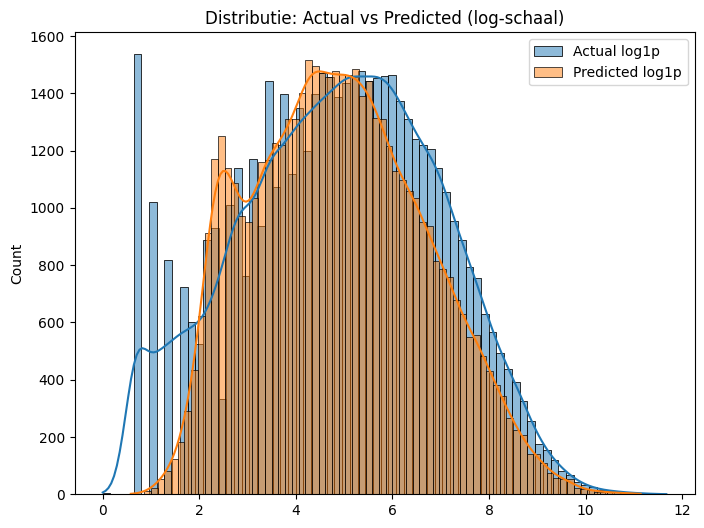

In [ ]:
y_true_log = y_train_all.values       
y_pred_log = y_pred_train_all        

y_true_orig = np.expm1(y_true_log)
y_pred_orig = np.expm1(y_pred_log)

plt.figure(figsize=(8,6))
sns.histplot(y_true_log, label='Actual log1p', kde=True)
sns.histplot(y_pred_log, label='Predicted log1p', kde=True)
plt.legend()
plt.title('Distribution: Actual vs Predicted (log-scale)')
plt.show()

In [ ]:
#Binning
train_eval = train_df_transformed.copy()
train_eval['y_true_orig'] = np.expm1(train_eval['totaal_minuten'])
group_means = train_eval.groupby('klant_grootte')['y_true_orig'].mean()


df_eval = test_df_transformed.copy()
df_eval['y_true']        = np.expm1(y_test)                        # echte minuten
df_eval['y_pred']        = np.expm1(y_test_pred)                   # XGB‐model
df_eval['abs_err']       = (df_eval['y_true'] - df_eval['y_pred']).abs()

# Baseline 1: bin‐mean 
df_eval['baseline_pred'] = df_eval['klant_grootte'].map(group_means)
df_eval['baseline_pred'] = df_eval['baseline_pred'].fillna(group_means.mean())
df_eval['baseline_err']  = (df_eval['y_true'] - df_eval['baseline_pred']).abs()

# Baseline 2: t–1 naive 
df_eval['tminus1_pred'] = np.expm1(df_eval['totaal_minuten_tminus1'])
df_eval['tminus1_err']  = (df_eval['y_true'] - df_eval['tminus1_pred']).abs()

#Per‐group summary: MAE model
summary_per_group = (
    df_eval
    .groupby('klant_grootte', as_index=False)
    .agg(
        MAE_model      = ('abs_err',      'mean'),
        MAE_bin_mean   = ('baseline_err', 'mean'),
        MAE_tminus1    = ('tminus1_err',  'mean'),
        Mean_duration  = ('y_true',       'mean'),
        n_obs          = ('abs_err',      'size')
    )
    .sort_values('klant_grootte')
)
print(summary_per_group)

#Overall MAE 
overall_mae_model     = mean_absolute_error(df_eval['y_true'], df_eval['y_pred'])
overall_mae_bin_mean  = mean_absolute_error(df_eval['y_true'], df_eval['baseline_pred'])
overall_mae_tminus1   = mean_absolute_error(df_eval['y_true'], df_eval['tminus1_pred'])

print(f"\nOverall model MAE:       {overall_mae_model:.2f} min")
print(f"Overall bin‐mean MAE:    {overall_mae_bin_mean:.2f} min")
print(f"Overall t–1 baseline MAE:{overall_mae_tminus1:.2f} min")


   klant_grootte  MAE_model  MAE_bin_mean  MAE_tminus1  Mean_duration  n_obs
0              1         62           114           84             84   1310
1              2         98           164          129            128   1077
2              3         96           172          136            135   1002
3              4        135           219          189            189   1015
4              5        163           273          240            240    951
5              6        253           374          380            380    992
6              7        286           438          451            452    940
7              8        476           700          766            767    908
8              9        993          1311         1564           1566    859
9             10       2627          4090         5121           5126    864

Overall model MAE:       468.86 min
Overall bin‐mean MAE:    711.68 min
Overall t–1 baseline MAE:813.81 min


C:\Users\matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


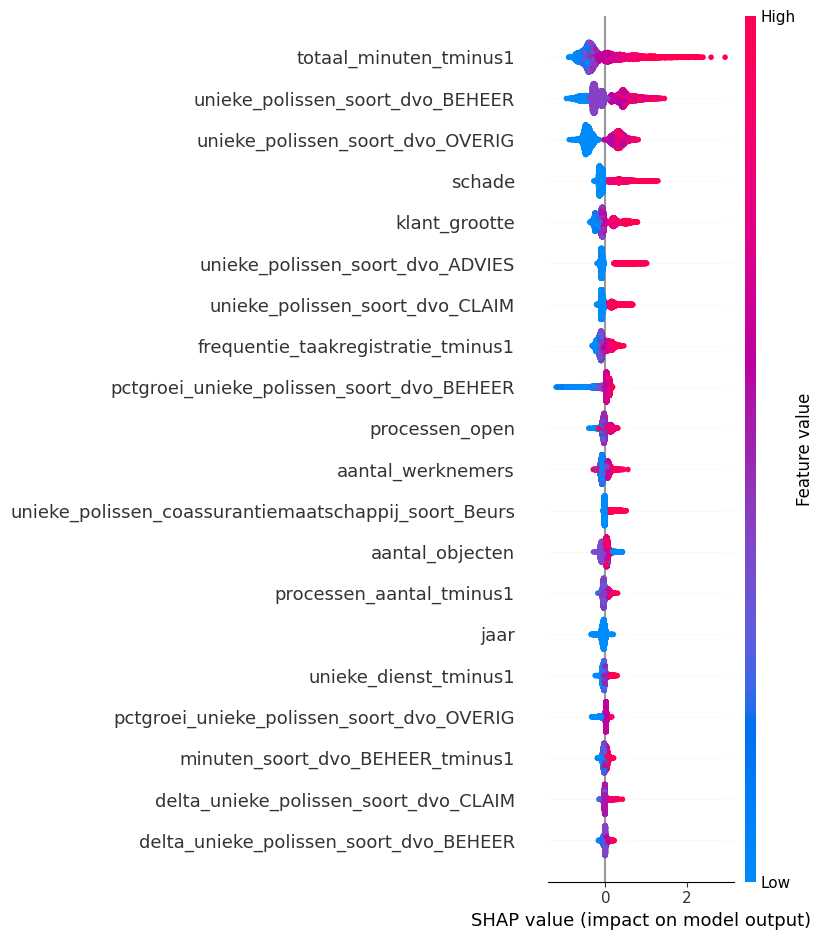

In [ ]:
#SHAP-explainer
explainer = shap.TreeExplainer(best_model, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist())
plt.show()

